# ${\color{pink}\mathbb{Q-Learning-Matala-4}}$

##### ${\color{magenta}\mathbb{Matan-Ginzburg-21}}$

### ${\color{cyan}{\text{Frozen Lake}}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.spaces import Discrete, Tuple

#import pygame
#import time
from pprint import pprint
from matplotlib.colors import to_rgb
from matplotlib.colors import to_rgba_array

# ${\color{pink}\mathbb{Preparations}}$

## ${\color{pink}\mathbb{Draw-Plot}}$

In [2]:
def get_tile_type(env, state):
    desc = env.desc.astype(str)  # Convert bytes to strings if necessary
    ncols = desc.shape[1]
    row, col = divmod(state, ncols)
    return desc[row][col]

In [3]:
def plot_policy(env, policy, Q, title="Policy with Q-values"):
    desc = env.unwrapped.desc.astype(str)
    nrows, ncols = desc.shape
    P = np.array(policy).reshape((nrows, ncols))

    arrow_map = ["←", "↓", "→", "↑"]
    policy_arrows = np.array([arrow_map[a] for a in P.flatten()]).reshape((nrows, ncols))

    # Background colors
    colors = np.empty((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            if desc[i, j] == "H":
                colors[i, j] = "#FFFF00"  # hole - yellow
            elif desc[i, j] == "G":
                colors[i, j] = "#00FF00"  # goal - green
            else:
                colors[i, j] = "#ADD8E6"  # normal - light blue

    colors_rgba = to_rgba_array(colors.reshape(-1)).reshape((nrows, ncols, 4))

    fig, ax = plt.subplots(figsize=(ncols * 1.8, nrows * 1.8))
    ax.imshow(colors_rgba)

    for i in range(nrows):
        for j in range(ncols):
            state = i * ncols + j
            tile = desc[i, j]

            # Show tile type above the top Q-value
            ax.text(j, i - 0.35, tile, color="purple", ha="center", va="center", fontsize=12, fontweight="bold")

            if tile in ("H", "G"):
                continue  # No arrows or Q-values on terminal states

            # Draw the policy arrow in the center
            ax.text(j, i, policy_arrows[i, j], color="red", ha="center", va="center", fontsize=18, fontweight="bold")

            # Q-values
            q_vals = Q[state]
            ax.text(j - 0.25, i,     f"{q_vals[0]:.2f}", fontsize=8, color="black", ha="right", va="center")   # ←
            ax.text(j,         i + 0.25, f"{q_vals[1]:.2f}", fontsize=8, color="black", ha="center", va="bottom")  # ↓
            ax.text(j + 0.25, i,     f"{q_vals[2]:.2f}", fontsize=8, color="black", ha="left", va="center")    # →
            ax.text(j,         i - 0.15, f"{q_vals[3]:.2f}", fontsize=8, color="black", ha="center", va="top")     # ↑

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_value_function(V, title="Value Function"):
    V = V.reshape((4, 5))
    plt.figure(figsize=(6, 6))
    sns.heatmap(V, annot=True, cmap="coolwarm", cbar=False, square=True, linewidths=0.5)
    plt.title(title)
    plt.show()

# ${\color{pink}\mathbb{Class}}$

# ${\color{pink}\mathbb{Class}}$

##### ${\color{cyan}{\text{Creating Env with rewards and probabilties.}}}$

In [5]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="4x5", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob

        self.desc = np.asarray([
                            "SFFFF",
                            "FFFFH",
                            "FFHFF",
                            "FFFFG"
                                ], dtype="c")

        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                rew = self.get_tile_reward(newletter)       #to change for custom rewards...
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, rew, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            rew = float(newletter == b"G")
                            li.append((1.0, newstate, rew, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}
    
    def get_tile_reward(self,tile):
    
        if tile == b'S':
            return -0.08  
        elif tile == b'F':
            return -0.08  
        elif tile == b'H':
            return -1.0
        elif tile == b'G':
            return 1.0
        else:
            return 0.0   

In [6]:
gym.envs.registration.register(
        id="CustomFrozenLake-v0",
        entry_point=__name__ + ":CustomFrozenLakeEnv",
    )

----

## ${\color{pink}\mathbb{Q-Learning}}$

## ${\color{pink}\mathbb{Episode}}$

----

----

$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, ..., S_T$



$$ Q(S, A) =  Q(S, A) + \alpha \cdot (R + \gamma \cdot max_a [Q(S',a)] - Q(S, A))$$

In [7]:
def get_q(s,a,next_s,r,my_q,alpha,gamma):

        max_q_next = np.max(my_q[next_s])

        return my_q[s][a] + alpha * ( r + gamma* max_q_next - my_q[s][a] )

In [8]:
def epsilon_greedy_policy(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])  #greedy


----

In [9]:
def q_learning_yes(env ,alpha=0.1, gamma=0.99, epsilon=0.1, num_episodes=5000):
    
    n_states = env.observation_space.n    
    n_actions = env.action_space.n
    
    my_q = np.zeros((n_states,n_actions))                       #initialize !
    policy = np.random.choice(range(n_actions), size=n_states)

    max_steps = 500 
    for eps in range(num_episodes):

        
        steps = 0
        done = False
        alpha = 1/(eps+1)     #1/num_episode..

        curr_s = env.reset()[0]                                 #S
        

        while not done and steps < max_steps:       #steps in our episodes ! 
            
            curr_a = epsilon_greedy_policy(curr_s,my_q,epsilon)     #A

            next_s, r, terminated, truncated, _ = env.step(curr_a)  #S' r 
            done = terminated or truncated

            my_q[curr_s][curr_a] = get_q(curr_s,curr_a,next_s,r,my_q,alpha,gamma)     #change only current...

            curr_s = next_s             #S -> S'
            steps += 1 


    for state in range(n_states):  #לבדוק לכולם!
        policy[state] = np.argmax(my_q[state])
        

    return policy,my_q

In [10]:
env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)
P = env.unwrapped.P
n_states = env.observation_space.n    
n_actions = env.action_space.n
print(P[0])

policy_q,my_q_learend = q_learning_yes(env, alpha=0.1, gamma=0.99, epsilon=0.0001, num_episodes=50000)

{0: [(0.1, 0, -0.08, False), (0.8, 0, -0.08, False), (0.1, 5, -0.08, False)], 1: [(0.1, 0, -0.08, False), (0.8, 5, -0.08, False), (0.1, 1, -0.08, False)], 2: [(0.1, 5, -0.08, False), (0.8, 1, -0.08, False), (0.1, 0, -0.08, False)], 3: [(0.1, 1, -0.08, False), (0.8, 0, -0.08, False), (0.1, 0, -0.08, False)]}


In [11]:
print("Policy: ",policy_q)


Policy:  [2 2 2 1 0 1 2 2 1 0 1 1 0 2 1 2 2 2 2 0]


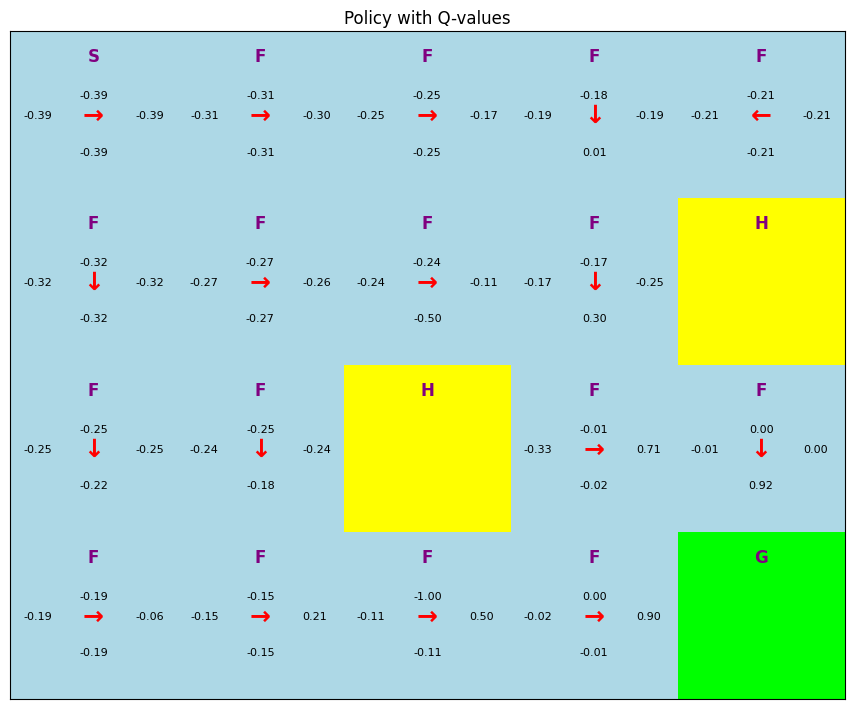

In [12]:
plot_policy(env,policy_q,my_q_learend)

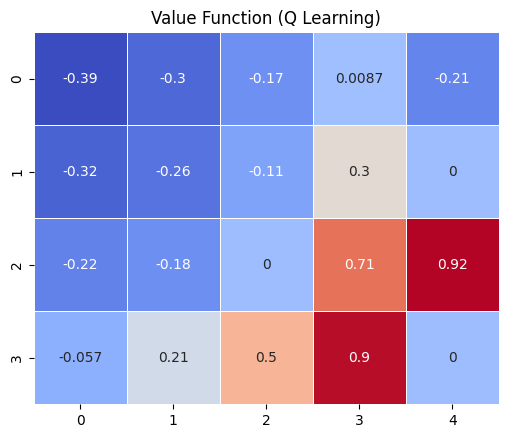

In [24]:
plot_value_function(np.max(my_q_learend, axis=1), title="Value Function (Q Learning)")

-----

----

# ${\color{pink}\mathbb{10x10}}$

### ${\color{cyan}{\text{Lets See how it is?}}}$

In [14]:
class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="10x10", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob

        self.desc = np.asarray(generate_random_map(size=10, p=0.8), dtype="c")      #generate random 10x10


        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                rew = self.get_tile_reward(newletter)       #to change for custom rewards...
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, rew, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            rew = float(newletter == b"G")
                            li.append((1.0, newstate, rew, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}
    
    def get_tile_reward(self,tile):
    
        if tile == b'S':
            return -0.08  
        elif tile == b'F':
            return -0.08  
        elif tile == b'H':
            return -1.0
        elif tile == b'G':
            return 1.0
        else:
            return 0.0   

In [15]:
gym.envs.registration.register(
        id="FrozenLake-10x10-yooo-Custom-v0",
        entry_point=__name__ + ":CustomFrozenLakeEnv",
    )

In [22]:
env = gym.make("FrozenLake-10x10-yooo-Custom-v0", is_slippery=True, slip_prob=0.2)

P = env.unwrapped.P
n_states = env.observation_space.n    
n_actions = env.action_space.n
print(P[0])

policy_q_10,my_q_learend_10 = q_learning_yes(env, alpha=0.1, gamma=0.99, epsilon=0.0001, num_episodes=1000000)


{0: [(0.1, 0, -0.08, False), (0.8, 0, -0.08, False), (0.1, 10, -0.08, False)], 1: [(0.1, 0, -0.08, False), (0.8, 10, -0.08, False), (0.1, 1, -0.08, False)], 2: [(0.1, 10, -0.08, False), (0.8, 1, -0.08, False), (0.1, 0, -0.08, False)], 3: [(0.1, 1, -0.08, False), (0.8, 0, -0.08, False), (0.1, 0, -0.08, False)]}


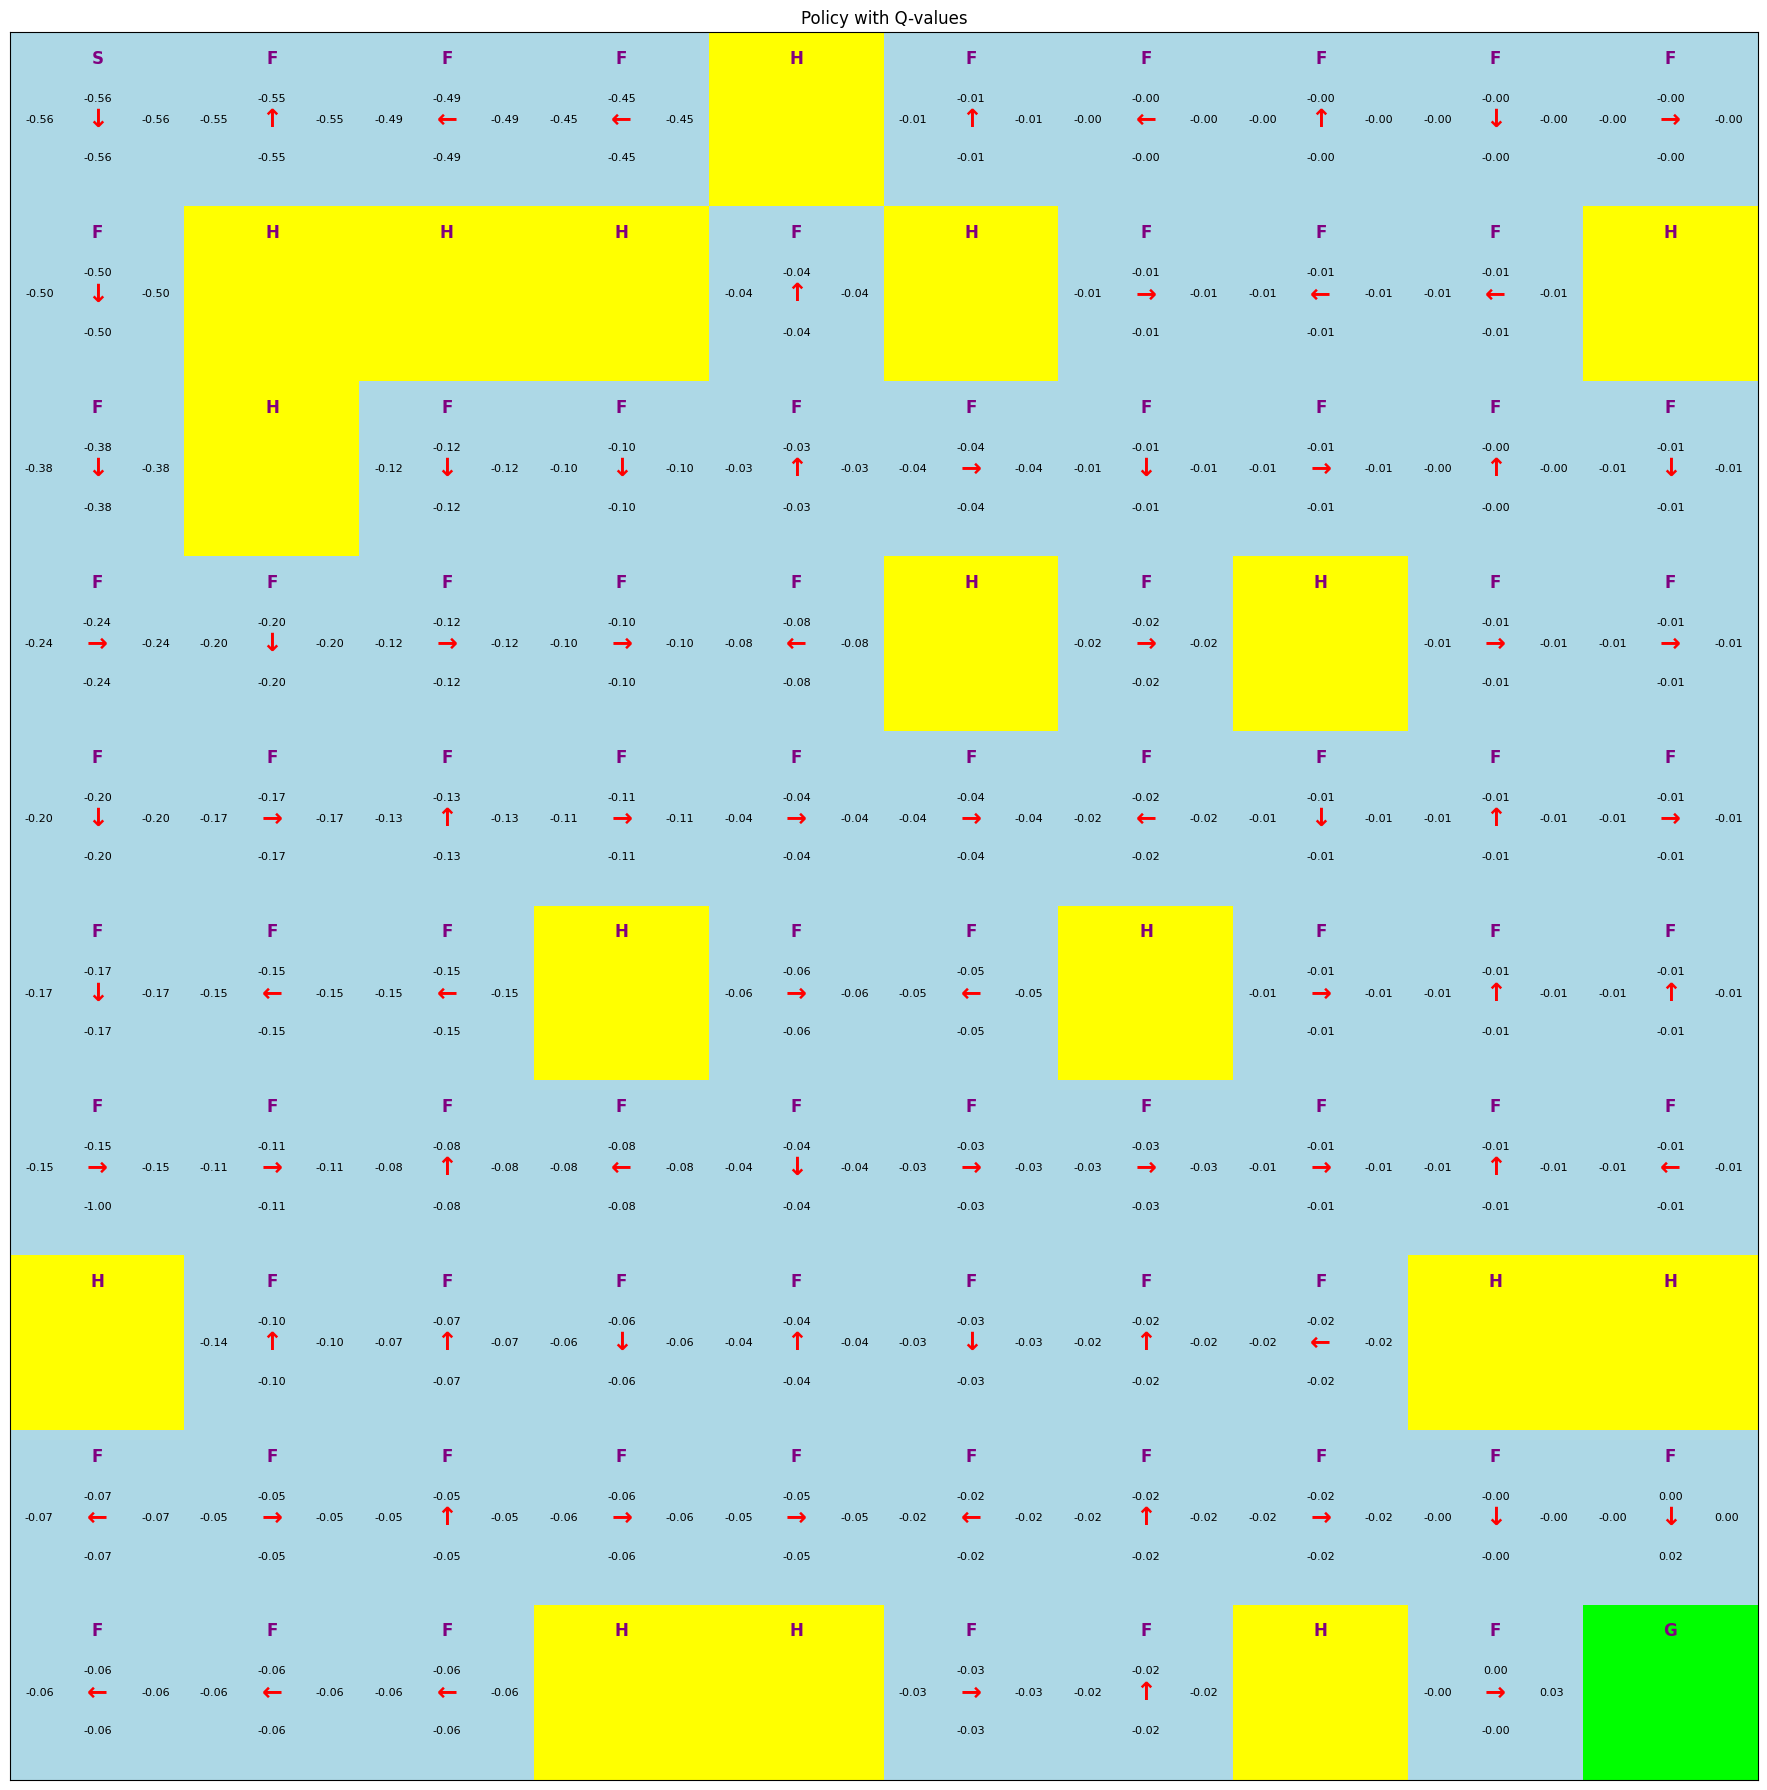

In [21]:
plot_policy(env,policy_q_10,my_q_learend_10)

### ${\color{cyan}{\text{Not the best...}}}$

### ${\color{cyan}{\text{But as expected a lot of times it would prefer to go out of the wall or even fall to the hole, because it think that it will be a lower rewards then going all the way to the Goal which is -0.08 for each tile....}}}$